# KNN, рак и спам
__Суммарное количество баллов: 10__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [203]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно.

In [204]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pd.read_csv(path_to_csv)
    df = df.sample(frac=1)
#     print(df)
    y=df["label"]
    y = pd.get_dummies(y)["M"]
    x = df.iloc[:, 1:]
    return x,y

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pd.read_csv(path_to_csv)
    df = df.sample(frac=1)
    y = df["label"]
    x = df.loc[:, :"capital_run_length_total"]
    return x,y
print(read_cancer_dataset("cancer.csv")[:])
read_spam_dataset("spam.csv")[1]

(         1      2       3       4        5        6        7        8       9  \
269  10.71  20.39   69.50   344.9  0.10820  0.12890  0.08448  0.02867  0.1668   
19   13.54  14.36   87.46   566.3  0.09779  0.08129  0.06664  0.04781  0.1885   
554  12.88  28.92   82.50   514.3  0.08123  0.05824  0.06195  0.02343  0.1566   
492  18.01  20.56  118.40  1007.0  0.10010  0.12890  0.11700  0.07762  0.2116   
48   12.05  14.63   78.04   449.3  0.10310  0.09092  0.06592  0.02749  0.1675   
..     ...    ...     ...     ...      ...      ...      ...      ...     ...   
496  12.65  18.17   82.69   485.6  0.10760  0.13340  0.08017  0.05074  0.1641   
431  12.40  17.68   81.47   467.8  0.10540  0.13160  0.07741  0.02799  0.1811   
5    12.45  15.70   82.57   477.1  0.12780  0.17000  0.15780  0.08089  0.2087   
519  12.75  16.70   82.51   493.8  0.11250  0.11170  0.03880  0.02995  0.2120   
105  13.11  15.56   87.21   530.2  0.13980  0.17650  0.20710  0.09601  0.1925   

          10  ...     21  

2648    0
4401    0
3700    0
1049    1
4041    0
       ..
642     1
4195    0
899     1
1892    0
657     1
Name: label, Length: 4601, dtype: int64

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [205]:
from sklearn.model_selection import train_test_split as tts
def train_test_split(X, y, ratio):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=1-ratio)
    return X_train, y_train, X_test, y_test
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
x,y = read_cancer_dataset("cancer.csv")
train_test_split(x,y, 0.9)

(         1      2       3       4        5        6        7        8       9  \
 143  12.90  15.92   83.74   512.2  0.08677  0.09509  0.04894  0.03088  0.1778   
 132  16.16  21.54  106.20   809.8  0.10080  0.12840  0.10430  0.05613  0.2160   
 77   18.05  16.15  120.20  1006.0  0.10650  0.21460  0.16840  0.10800  0.2152   
 203  13.81  23.75   91.56   597.8  0.13230  0.17680  0.15580  0.09176  0.2251   
 369  22.01  21.90  147.20  1482.0  0.10630  0.19540  0.24480  0.15010  0.1824   
 ..     ...    ...     ...     ...      ...      ...      ...      ...     ...   
 430  14.90  22.53  102.10   685.0  0.09947  0.22250  0.27330  0.09711  0.2041   
 268  12.87  16.21   82.38   512.2  0.09425  0.06219  0.03900  0.01615  0.2010   
 98   11.60  12.84   74.34   412.6  0.08983  0.07525  0.04196  0.03350  0.1620   
 288  11.26  19.96   73.72   394.1  0.08020  0.11810  0.09274  0.05588  0.2595   
 33   19.27  26.47  127.90  1162.0  0.09401  0.17190  0.16570  0.07593  0.1853   
 
           10 

### Задание 3 (3 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [206]:
def get_precision_recall_accuracy(y_pred, y_true): 
    y_true = y_true.reset_index(drop = True)
    precs = []
    recs = []
    accs = []
    for c in np.unique(list(y_train) + list(y_test)):
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        for i in range(len(y_pred)):
            if y_pred[i] == y_true[i]:
                if y_pred[i] == c:
                    tp+=1
                else:
                    tn+=1
            else:
                if y_pred[i] == c:
                    fp+=1
                else:
                    fn+=1
        prec = None
        rec = None
        acc = None
    #     print(tp,fp,tn,fn)
        if tp+fp != 0:
            prec = tp / (tp+fp)
        if tp+fn != 0:
            rec = tp / (tp+fn)
        if tp+fp+tn+fn != 0:
            acc = (tp + tn) / (tp + fp + tn + fn)
        precs.append(prec)
        recs.append(rec)
        accs.append(acc)
    return precs, recs, accs
            
        
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
get_precision_recall_accuracy([0,1,1],pd.Series([1,0,1]))

([0.0, 0.5], [0.0, 0.5], [0.3333333333333333, 0.3333333333333333])

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [207]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [208]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 5  (5 баллов)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [209]:
from sklearn.neighbors import KDTree
class KNearest:
    n_neighbors = None
    leaf_size = None
    tree = None
    y = None
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
    
    def fit(self, X, y):
        self.y = y.reset_index(drop = True)
        self.tree = KDTree(X, leaf_size=self.leaf_size)   
        
    def predict_proba(self, X):
        res=[]
        dist, ind = self.tree.query(X, k=self.n_neighbors) 
#         print(ind)
#         print(X, self.y)
        for neighbs in ind:
            tmp = [0 for _ in range(max(self.y)+1)]
            for neighbr in neighbs:
                tmp[self.y[neighbr]]+=1
            tmp = list(map(lambda x: x/self.n_neighbors,tmp))
            res.append(tmp)
        return res   
            
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
#         raise NotImplementedError()
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
classif = KNearest(2)
classif.fit(np.array([[1,1,1], [10,10,10], [5,5,5], [6,6,6],[11,11,15]]), pd.Series([1,0,2,2,0]))
print(classif.predict_proba([[5,5,6], [10,10,9]]))
print(classif.predict([[5,5,6], [10,10,9]]))


[[0.0, 0.0, 1.0], [1.0, 0.0, 0.0]]
[2 0]


Наконец, протестируем наш классификатор на различных наборах данных

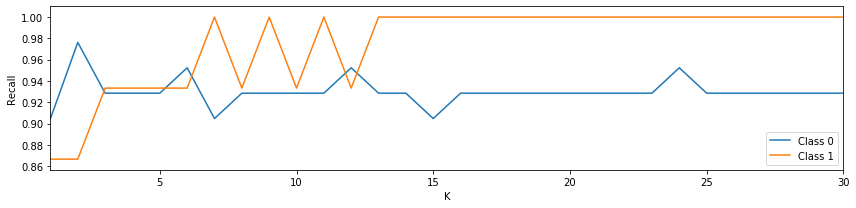

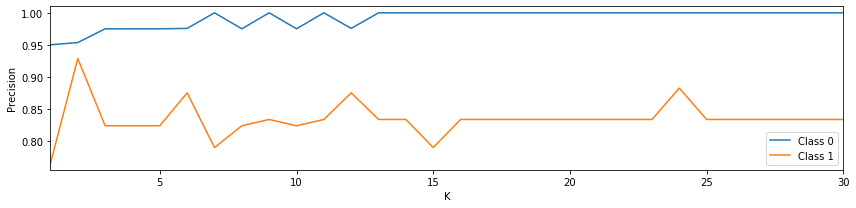

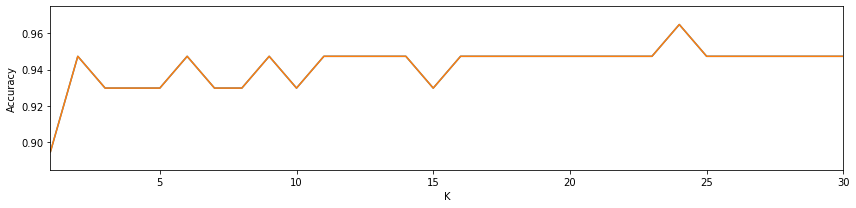

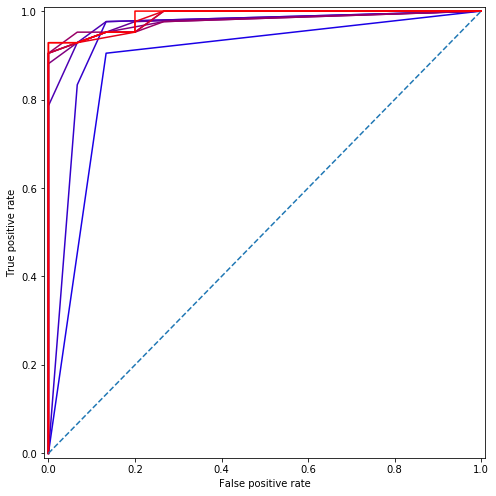

In [212]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

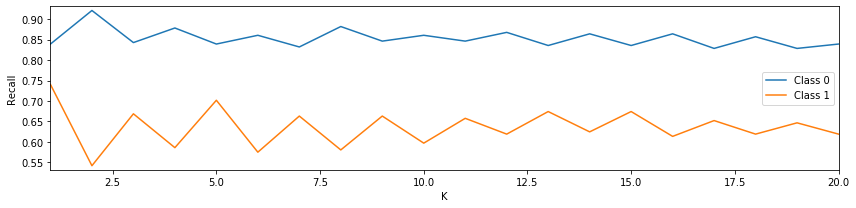

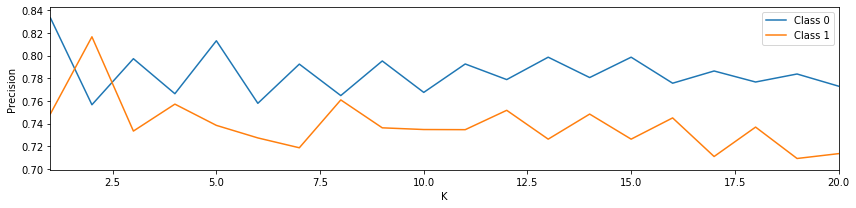

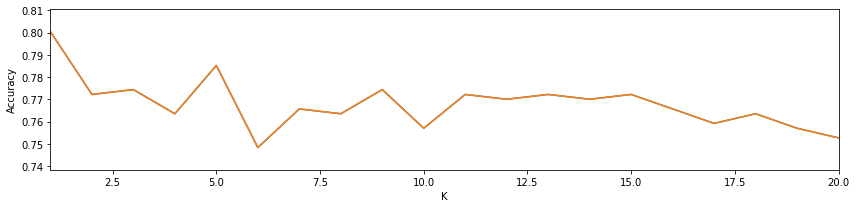

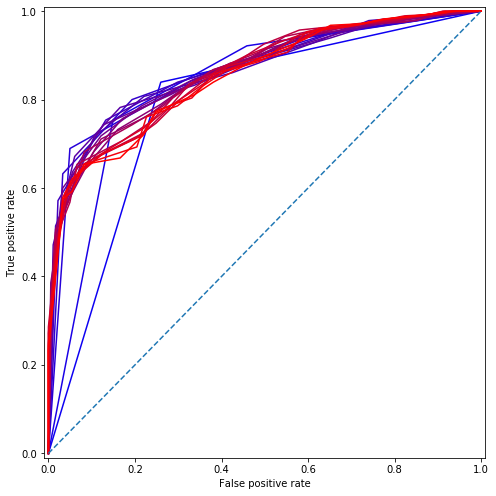

In [213]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)